In [22]:
from data_sampling import verify_samples
import pandas as pd

verify_samples()

batch_size = 4096
STROKE_COUNT = 196
TRAIN_SAMPLES = 750
VALID_SAMPLES = 75
TEST_SAMPLES = 50
size = 32

def get_available_gpus():
    from tensorflow.python.client import device_lib
    return device_lib.list_local_devices()
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [23]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pandas as pd
def top_3_accuracy(x,y): return top_k_categorical_accuracy(x,y, 3)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from glob import glob
import gc
gc.enable()

In [24]:
from ast import literal_eval
*FILES, = filter(lambda x:x[0]!='.',os.listdir('train_sampled'))
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

def read_batch(base, files):
    out_df_list = []
    for c_path in files:
        c_path = os.path.join(base, c_path)
        c_df = pd.read_csv(c_path, engine='python')
        c_df.columns=COL_NAMES
        out_df_list += [c_df[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    
    return full_df

In [25]:
train_df = read_batch('train_sampled',FILES)
valid_df = read_batch('valid_sampled',FILES)
test_df = read_batch('test_sampled',FILES)
word_encoder = LabelEncoder()
word_encoder.fit(train_df['word'])

LabelEncoder()

In [26]:
if len(get_available_gpus())>0:
    print('use GPU')

use GPU


In [58]:
import cv2

BASE_SIZE = 256

def draw_cv2(raw_strokes, size=256, lw=6):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def df_to_image_array(df, size, lw=6):
    df['drawing'] = df['drawing'].apply(literal_eval)
    x = np.zeros((len(df), size, size))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = x / 255.
    x = x.reshape((len(df), size, size, 1)).astype(np.float32)
    return x

def get_Xy(in_df):
    global size
    X = df_to_image_array(in_df, size)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)
print(train_X.shape)

(200000, 32, 32, 1)


In [64]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(size, size, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(100, activation='softmax'))
model.compile(optimizer = 'adam', 
                loss = 'categorical_crossentropy', 
                metrics = ['categorical_accuracy', top_3_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               100480    
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
__________

In [65]:
weight_path="{}_weights.best.hdf5".format('image_cnn_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, 
                                   verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [66]:
import time
from IPython.display import clear_output
t_start = time.time()
model.fit(train_X, train_y,
                      validation_data = (valid_X, valid_y), 
                      batch_size = batch_size,
                      epochs = 50,
                      callbacks = callbacks_list)
clear_output()
t_end = time.time()
print('Train finished with',t_end-t_start,'second(s)')

Train finished with 298.1098098754883 second(s)


In [67]:
model.load_weights(weight_path)
lstm_results = model.evaluate(test_X, test_y, batch_size = 4096)
print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results[1], 100*lstm_results[2]))

10000/10000 [==============================] - 0s 14us/step
Accuracy: 64.0%, Top 3 Accuracy 81.1%


                  precision    recall  f1-score   support

        airplane       0.63      0.66      0.64       100
     alarm clock       0.67      0.70      0.69       100
       ambulance       0.66      0.77      0.71       100
           angel       0.62      0.63      0.62       100
animal migration       0.59      0.58      0.59       100
             ant       0.50      0.57      0.53       100
           anvil       0.70      0.76      0.73       100
           apple       0.80      0.79      0.79       100
             arm       0.53      0.50      0.51       100
       asparagus       0.66      0.69      0.68       100
             axe       0.70      0.77      0.73       100
        backpack       0.62      0.71      0.66       100
          banana       0.79      0.83      0.81       100
         bandage       0.76      0.75      0.75       100
            barn       0.70      0.71      0.71       100
        baseball       0.85      0.68      0.76       100
    baseball 

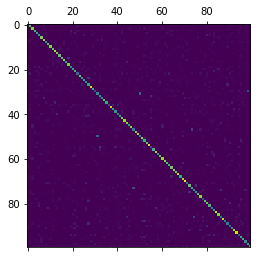

In [68]:
from sklearn.metrics import confusion_matrix, classification_report
test_cat = np.argmax(test_y, 1)
pred_y = model.predict(test_X, batch_size = 4096)
pred_cat = np.argmax(pred_y, 1)
plt.matshow(confusion_matrix(test_cat, pred_cat))
print(classification_report(test_cat, pred_cat, 
                            target_names = [x for x in word_encoder.classes_]))

In [12]:
# 